In [1]:
import torch
import os
import numpy as np
from torchvision import transforms
from PIL import Image
from IPython.display import clear_output

In [2]:
device = torch.device("cuda")

In [3]:
def zoom_in_crop(img):
    img = img[0:3,:,:]
    c, h, w = img.shape
    
    if w/h <= 2.4:
        crop_h = int(w/2.4)
        crop_w = w
        crop_loc_h = int((h - crop_h) / 2)
        cropped_img = img[:,crop_loc_h:crop_h+crop_loc_h,:crop_w]
    
    else:
        crop_h = h
        crop_w = int(h*2.4)
        crop_loc_w = int((w - crop_w) / 2)
        cropped_img = img[:,:crop_h,crop_loc_w:crop_w+crop_loc_w]
    
  
    resized_img = transforms.Resize((160, 384))(cropped_img)
    return resized_img

def zoom_out_crop(img):
    img = img[0:3,:,:]
    c, h, w = img.shape
    aspect_ratio = w/h
    zeros_grid = torch.zeros(3,160,384)

    if w/h <= 2.4:
        new_h = 160
        new_w = int(aspect_ratio * new_h)
    else:
        new_w = 384
        new_h = int(new_w / aspect_ratio)


    resized_img = transforms.Resize((new_h, new_w))(img)
    left_pad = int((384-new_w)/2)
    right_pad = 384 - new_w - left_pad
    top_pad = int((160-new_h)/2)
    bottom_pad = 160 - new_h - top_pad
    padded_image = torch.nn.functional.pad(resized_img, (left_pad, right_pad, top_pad, bottom_pad))
    return padded_image

  

In [4]:
class hair_implants():
    def __init__ (self, num_pictures,start_of_seq = None):
        pic_location = "C:/Users/shmue/OneDrive/Desktop/3D_AI/NewTsukubaStereoDataset/illumination/daylight/left"
        y_pics = "C:/Users/shmue/OneDrive/Desktop/3D_AI/NewTsukubastereoDataset/illumination/daylight/right"
        data = os.listdir(pic_location)
        if start_of_seq == None:
            data = np.random.choice(data, num_pictures)
        else:
            start_of_seq = start_of_seq % (len(data) - 10)
            data = data[start_of_seq:start_of_seq+10]
        self.data = data
        y_data = [file_name.replace('L', 'R') for file_name in self.data]
        self.y_data = y_data
        convert_tensor = transforms.ToTensor()
        pic_width = 384
        pic_height = 160        
        self.bag_of_hair = torch.zeros((num_pictures, 3 * pic_width * pic_height), device = device, dtype = torch.float32)
        self.y_values = torch.zeros((num_pictures, 3 * pic_width * pic_height), device = device, dtype = torch.float32)
        for t, hair in enumerate(data):
            img = Image.open(pic_location + "/" + hair)
            converted_tensor = zoom_out_crop(convert_tensor(img))
            self.bag_of_hair[t,:] = torch.flatten(converted_tensor)
        for t, hair in enumerate(y_data):
            img = Image.open(y_pics + "/" + hair)
            converted_tensor = zoom_out_crop(convert_tensor(img))
            self.y_values[t, :] = torch.flatten(converted_tensor)
        
        
        
     

In [5]:
pic_location = "C:/Users/shmue/girl.jpg"
convert_tensor = transforms.ToTensor()
img = Image.open(pic_location)
converted_tensor = convert_tensor(img)
if converted_tensor.shape[2]/converted_tensor.shape[1] <= 2.4:
    crop_h = int(converted_tensor.shape[2]/2.4)
    crop_w = converted_tensor.shape[2]
    crop_loc_h = int((converted_tensor.shape[1] - crop_h) / 2)
    cropped_img = converted_tensor[:,crop_loc_h:crop_h+crop_loc_h,:crop_w]
    
else:
    crop_h = converted_tensor.shape[1]
    crop_w = int(converted_tensor.shape[1]*2.4)
    crop_loc_w = int((converted_tensor.shape[2] - crop_w) / 2)
    cropped_img = converted_tensor[:,:crop_h,crop_loc_w:crop_w+crop_loc_w]

        


In [6]:
pic_location = "C:/Users/shmue/OneDrive/Desktop/3D_AI/NewTsukubaStereoDataset/illumination/daylight/left/tsukuba_daylight_L_00001.png"
convert_tensor = transforms.ToTensor()
img = Image.open(pic_location)
converted_tensor = convert_tensor(img)
transform = transforms.ToPILImage()
img = transform(zoom_out_crop(converted_tensor))
img.show()

In [7]:
'''print_pic = hair_implants(1)
x_image = print_pic.bag_of_hair[0]
y_image = print_pic.y_values[0]
reshaped_x = x_image.reshape(3,160,384)
reshaped_y = y_image.reshape(3,160,384)
transform = transforms.ToPILImage()
img_x = transform(zoom_out_crop(reshaped_x))
display(img_x)
img_y = transform(zoom_out_crop(reshaped_y))
display(img_y)'''

'print_pic = hair_implants(1)\nx_image = print_pic.bag_of_hair[0]\ny_image = print_pic.y_values[0]\nreshaped_x = x_image.reshape(3,160,384)\nreshaped_y = y_image.reshape(3,160,384)\ntransform = transforms.ToPILImage()\nimg_x = transform(zoom_out_crop(reshaped_x))\ndisplay(img_x)\nimg_y = transform(zoom_out_crop(reshaped_y))\ndisplay(img_y)'

In [8]:
class ai_3d(torch.nn.Module):
    def __init__(self):
        super(ai_3d, self).__init__()
        self.group_1_conv1 = torch.nn.Conv2d(3, 64, 3, padding =1, device=device,dtype=torch.float32)
        torch.nn.init.normal_(self.group_1_conv1.weight, mean=0.1 , std=0.05)
        self.group_1_relu1 = torch.nn.ReLU()
        self.group_1_pool1 = torch.nn.MaxPool2d(2, stride = 2)
        self.group_2_conv1 = torch.nn.Conv2d(64, 128, 3, padding =1, device=device,dtype=torch.float32)
        self.group_2_relu1 = torch.nn.ReLU()
        self.group_2_pool1 = torch.nn.MaxPool2d(2, stride = 2)
        self.group_3_conv1 = torch.nn.Conv2d(128, 256, 3, padding =1, device=device,dtype=torch.float32)
        self.group_3_relu1 = torch.nn.ReLU()
        self.group_3_conv2 = torch.nn.Conv2d(256, 256, 3, padding =1, device=device,dtype=torch.float32)
        self.group_3_relu2 = torch.nn.ReLU()
        self.group_3_pool1 = torch.nn.MaxPool2d(2, stride = 2)
        self.group_4_conv1 = torch.nn.Conv2d(256, 512, 3, padding =1, device=device,dtype=torch.float32)
        self.group_4_relu1 = torch.nn.ReLU()
        self.group_4_conv2 = torch.nn.Conv2d(512, 512, 3, padding =1, device=device,dtype=torch.float32)
        self.group_4_relu2 = torch.nn.ReLU()
        self.group_4_pool1 = torch.nn.MaxPool2d(2, stride = 2)
        self.group_5_conv1 = torch.nn.Conv2d(512, 512, 3, padding =1, device=device,dtype=torch.float32)
        self.group_5_relu1 = torch.nn.ReLU()
        self.group_5_conv2 = torch.nn.Conv2d(512, 512, 3, padding =1, device=device,dtype=torch.float32)
        self.group_5_relu2 = torch.nn.ReLU()
        self.group_5_pool1 = torch.nn.MaxPool2d(2, stride = 2)
        self.group_6_flatten1 = torch.nn.Flatten()
        self.group_6_fc1 = torch.nn.Linear(30720, 512, device=device,dtype=torch.float32)
        self.group_6_relu1 = torch.nn.ReLU()
        self.group_6_drop1 = torch.nn.Dropout()
        self.group_7_fc1 = torch.nn.Linear(512, 512, device=device,dtype=torch.float32)
        self.group_7_relu1 = torch.nn.ReLU()
        self.group_7_drop1 = torch.nn.Dropout()
        self.group_8_fc1 = torch.nn.Linear(512, 1980, device=device,dtype=torch.float32)
        self.bn_pool4 = torch.nn.BatchNorm2d(512, device=device)
        self.pred4 = torch.nn.Conv2d(512, 33, 3, stride = 1, padding =0, device=device,dtype=torch.float32)
        self.bn_pool3 = torch.nn.BatchNorm2d(256, device=device)
        self.pred3 = torch.nn.Conv2d(256, 33, 3, stride = 1, padding =0, device=device,dtype=torch.float32)
        self.bn_pool2 = torch.nn.BatchNorm2d(128, device=device)
        self.pred2 = torch.nn.Conv2d(128, 33, 3, stride = 1, padding =0, device=device,dtype=torch.float32)
        self.bn_pool1 = torch.nn.BatchNorm2d(64, device=device)
        self.pred1 = torch.nn.Conv2d(64, 33, 3, stride = 1, padding =0, device=device,dtype=torch.float32)
        scale = 1 #1
        self.pred_1_relu = torch.nn.ReLU()
        self.pred_1_convt = torch.nn.ConvTranspose2d(33, 33, 1+2, stride = 1, padding =0, bias = False, device=device,dtype=torch.float32)
        scale *= 2 #2
        self.pred_2_relu = torch.nn.ReLU()
        self.pred_2_convt = torch.nn.ConvTranspose2d(33, 33, 2*scale+4, stride = scale, padding =scale//2, bias = False, device=device,dtype=torch.float32)
        scale *= 2 #4
        self.pred_3_relu = torch.nn.ReLU()
        self.pred_3_convt = torch.nn.ConvTranspose2d(33, 33, 2*scale+8, stride = scale, padding =scale//2, bias = False, device=device,dtype=torch.float32)
        scale *= 2 #8
        self.pred_4_relu = torch.nn.ReLU()
        self.pred_4_convt = torch.nn.ConvTranspose2d(33, 33, 2*scale+16, stride = scale, padding =scale//2, bias = False, device=device,dtype=torch.float32)
        scale *= 2 #16
        self.pred_5_relu = torch.nn.ReLU()
        self.pred_5_convt = torch.nn.ConvTranspose2d(33, 33, 2*scale, stride = scale, padding =scale//2, bias = False, device=device,dtype=torch.float32)
        self.feat_act_relu = torch.nn.ReLU()
        scale = 2
        self.up_convt = torch.nn.ConvTranspose2d(33, 512, 2*scale, stride = scale, padding =scale//2, bias = False, device=device,dtype=torch.float32)
        self.up_relu = torch.nn.ReLU()
        self.up_conv = torch.nn.Conv2d(512, 33, 3, padding =1, device=device,dtype=torch.float32)
        self.output_conv = torch.nn.Conv2d(33, 3, 3, padding =1, device=device,dtype=torch.float32)
        





    def forward(self,x,dimensions):
        group_1 = self.group_1_conv1(x.reshape(-1, dimensions[0], dimensions[1], dimensions[2]))
        group_1 = self.group_1_relu1(group_1)
        group_1 = self.group_1_pool1(group_1)
        group_2 = self.group_2_conv1(group_1)
        group_2 = self.group_2_relu1(group_2)
        group_2 = self.group_2_pool1(group_2)
        group_3 = self.group_3_conv1(group_2)
        group_3 = self.group_3_relu1(group_3)
        group_3 = self.group_3_conv2(group_3)
        group_3 = self.group_3_relu2(group_3)
        group_3 = self.group_3_pool1(group_3)
        group_4 = self.group_4_conv1(group_3)
        group_4 = self.group_4_relu1(group_4)
        group_4 = self.group_4_conv2(group_4)
        group_4 = self.group_4_relu2(group_4)
        group_4 = self.group_4_pool1(group_4)
        group_5 = self.group_5_conv1(group_4)
        group_5 = self.group_5_relu1(group_5)
        group_5 = self.group_5_conv2(group_5)
        group_5 = self.group_5_relu2(group_5)
        group_5 = self.group_5_pool1(group_5)
        group_6 = self.group_6_flatten1(group_5)
        group_6 = self.group_6_fc1(group_6)
        group_6 = self.group_6_relu1(group_6)
        group_6 = self.group_6_drop1(group_6)
        group_7 = self.group_7_fc1(group_6)
        group_7 = self.group_7_relu1(group_7)
        group_7 = self.group_7_drop1(group_7)
        group_8_fc1 = self.group_8_fc1(group_7)
        pred5 = group_8_fc1.reshape(-1, 33, 12, 5) 
        bn_pool4 = self.bn_pool4(group_4)
        pred4 = self.pred4(bn_pool4)
        bn_pool3 = self.bn_pool3(group_3)
        pred3 = self.pred3(bn_pool3)
        bn_pool2 = self.bn_pool2(group_2)
        pred2 = self.pred2(bn_pool2)
        bn_pool1 = self.bn_pool1(group_1)
        pred1 = self.pred1(bn_pool1)
        pred1 = self.pred_1_relu(pred1)
        pred1 = self.pred_1_convt(pred1)
        pred2 = self.pred_2_relu(pred2)
        pred2 = self.pred_2_convt(pred2)
        pred3 = self.pred_3_relu(pred3)
        pred3 = self.pred_3_convt(pred3)
        pred4 = self.pred_4_relu(pred4)
        pred4 = self.pred_4_convt(pred4)
        pred5 = self.pred_5_relu(pred5)
        pred5 = self.pred_5_convt(pred5)
        feat = (pred1 + pred2 + pred3 + pred4 + pred5)
        feat_act_relu = self.feat_act_relu(feat)
        up = self.up_convt(feat_act_relu)
        up = self.up_relu(up)
        up = self.up_conv(up)
        up = self.output_conv(up)
        up = up.reshape(-1, 184320)
        return up
    
    def loss(self, input, target):
        loss_function = torch.nn.MSELoss()
        return loss_function(input, target)
    
def train(upload = False, save = False):
    model = ai_3d()
    if upload:
        model.load_state_dict(torch.load("garbage_bag_full_of_hair"))
    learning_rate = 1e-5
    epochs = 200
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
    transform = transforms.ToPILImage()
    for i in range(epochs):
        data = hair_implants(10,start_of_seq = i * 10)
        for j in range(data.bag_of_hair.shape[0]):
            results = model(data.bag_of_hair[j,:], (3, 384, 160))
            loss = model.loss(results,data.y_values[j,:])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 20 == 0:
            clear_output()
            print("epoch number - ", i ," - ",  loss.item())
            pic_transformed = transform(data.y_values[-1,:].reshape(3,160,384))
            display(pic_transformed)
            display(transform(results[-1,:].reshape(3,160,384)))
            if save:
                torch.save(model.state_dict(), "garbage_bag_full_of_hair")

epoch number -  20  -  0.027224132791161537


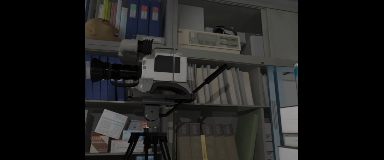

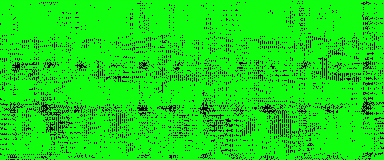

In [ ]:
while True:
    train(save = True, upload = True)

In [ ]:
hair = hair_implants(2)
model = ai_3d()
base_loss = model.loss(hair.bag_of_hair,hair.y_values)
print(base_loss)
output = model(hair.bag_of_hair, (3, 384, 160))
output.shape

In [ ]:
transform = transforms.ToPILImage()
img = transform(output[0].reshape(3,160,384))
img.show()

In [ ]:
https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
